### 反詐欺檢測
透過SVM 分類異常帳戶與非異常帳戶<br>
分類哪筆資料可能是可疑(詐欺)帳戶<br>

<br>
資料來源<br>
https://www.kaggle.com/code/x09072993/aml-detection/data

In [19]:
# 套件匯入
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns

In [20]:
# 设置随机种子
random.seed(50)
print(random.seed(50))
# 导入数据集
dataset = pd.read_csv('./input/PS_20174392719_1491204439457_log.csv')

None


In [21]:
# 初始資料
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [22]:
# 重複資料
print(f"Number of duplicate rows: {dataset.duplicated().sum()}")

In [ ]:
# 丟掉無關的特徵
dataset.drop('nameOrig', axis=1, inplace=True)
dataset.drop('nameDest', axis=1, inplace=True)
dataset.drop('isFlaggedFraud', axis=1, inplace=True)
print(dataset)

         step      type      amount  oldbalanceOrg  newbalanceOrig  \
0           1   PAYMENT     9839.64      170136.00       160296.36   
1           1   PAYMENT     1864.28       21249.00        19384.72   
2           1  TRANSFER      181.00         181.00            0.00   
3           1  CASH_OUT      181.00         181.00            0.00   
4           1   PAYMENT    11668.14       41554.00        29885.86   
...       ...       ...         ...            ...             ...   
6362615   743  CASH_OUT   339682.13      339682.13            0.00   
6362616   743  TRANSFER  6311409.28     6311409.28            0.00   
6362617   743  CASH_OUT  6311409.28     6311409.28            0.00   
6362618   743  TRANSFER   850002.52      850002.52            0.00   
6362619   743  CASH_OUT   850002.52      850002.52            0.00   

         oldbalanceDest  newbalanceDest  isFraud  
0                  0.00            0.00        0  
1                  0.00            0.00        0  
2     

In [ ]:
# 刪除遺漏值
dataset.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00


In [ ]:
sample_dataframe = dataset.sample(n=100000)
X = sample_dataframe.iloc[:, :-1].values
y = sample_dataframe.iloc[:, 7].values
print(sample_dataframe.isFraud.value_counts())
# print(x.dtypes)
# print(y.dtypes)

0    99860
1      140
Name: isFraud, dtype: int64


In [ ]:
# 編碼分類數據
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
import scipy.sparse
labelencoder = LabelEncoder()
X[:, 1] = labelencoder.fit_transform(X[:, 1])
onehotencoder = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(), [1])])
X = onehotencoder.fit_transform(X).toarray()

# 避免虛擬變量陷阱(Dummy Variable Trap)
# https: // www.cnblogs.com/HuZihu/p/11330853.html  # :~:text=%E8%99%9A%E6%8B%9F%E5%8F%98%E9%87%8F%E9%99%B7%E9%98%B1%EF%BC%88Dummy%20Variable%20Trap%EF%BC%89.%20%E8%99%9A%E6%8B%9F%E5%8F%98%E9%87%8F%E9%99%B7%E9%98%B1%EF%BC%88Dummy%20Variable%20Trap%EF%BC%89%20%EF%BC%9A%E6%8C%87%E5%BD%93%E5%8E%9F%E7%89%B9%E5%BE%81%E6%9C%89m%E4%B8%AA%E7%B1%BB%E5%88%AB%E6%97%B6%EF%BC%8C%E5%A6%82%E6%9E%9C%E5%B0%86%E5%85%B6%E8%BD%AC%E6%8D%A2%E6%88%90m%E4%B8%AA%E8%99%9A%E6%8B%9F%E5%8F%98%E9%87%8F%EF%BC%8C%E5%B0%B1%E4%BC%9A%E5%AF%BC%E8%87%B4%E5%8F%98%E9%87%8F%E9%97%B4%E5%87%BA%E7%8E%B0%E5%AE%8C%E5%85%A8%E5%85%B1%E7%BA%BF%E6%80%A7%E7%9A%84%E6%83%85%E5%86%B5%E3%80%82.%20%E5%81%87%E8%AE%BE%E6%88%91%E4%BB%AC%E6%9C%89%E4%B8%80%E4%B8%AA%E7%89%B9%E5%BE%81%E2%80%9C%E6%80%A7%E5%88%AB%E2%80%9D%EF%BC%8C%E5%8C%85%E5%90%AB%E7%94%B7%E6%80%A7%E5%92%8C%E5%A5%B3%E6%80%A7%E4%B8%A4%E4%B8%AA%E7%B1%BB%E5%88%AB%EF%BC%8C%E5%A6%82%E6%9E%9C%E5%B0%86%E6%AD%A4%E7%89%B9%E5%BE%81%E8%BD%AC%E6%8D%A2%E4%B8%BA2%E4%B8%AA%E8%99%9A%E6%8B%9F%E5%8F%98%E9%87%8F%EF%BC%8C%E5%B0%B1%E6%98%AF%EF%BC%9A%E7%94%B7x,1%20x%201%20%2Bw%202%20x%202%20%2Bb%E3%80%82.
X = X[:, 1:]

# Avoiding the Dummy Variable Trap
# X = X[:, 1:]

# 避免虛擬變量陷阱(Dummy Variable Trap)
# https: // www.cnblogs.com/HuZihu/p/11330853.html  # :~:text=%E8%99%9A%E6%8B%9F%E5%8F%98%E9%87%8F%E9%99%B7%E9%98%B1%EF%BC%88Dummy%20Variable%20Trap%EF%BC%89.%20%E8%99%9A%E6%8B%9F%E5%8F%98%E9%87%8F%E9%99%B7%E9%98%B1%EF%BC%88Dummy%20Variable%20Trap%EF%BC%89%20%EF%BC%9A%E6%8C%87%E5%BD%93%E5%8E%9F%E7%89%B9%E5%BE%81%E6%9C%89m%E4%B8%AA%E7%B1%BB%E5%88%AB%E6%97%B6%EF%BC%8C%E5%A6%82%E6%9E%9C%E5%B0%86%E5%85%B6%E8%BD%AC%E6%8D%A2%E6%88%90m%E4%B8%AA%E8%99%9A%E6%8B%9F%E5%8F%98%E9%87%8F%EF%BC%8C%E5%B0%B1%E4%BC%9A%E5%AF%BC%E8%87%B4%E5%8F%98%E9%87%8F%E9%97%B4%E5%87%BA%E7%8E%B0%E5%AE%8C%E5%85%A8%E5%85%B1%E7%BA%BF%E6%80%A7%E7%9A%84%E6%83%85%E5%86%B5%E3%80%82.%20%E5%81%87%E8%AE%BE%E6%88%91%E4%BB%AC%E6%9C%89%E4%B8%80%E4%B8%AA%E7%89%B9%E5%BE%81%E2%80%9C%E6%80%A7%E5%88%AB%E2%80%9D%EF%BC%8C%E5%8C%85%E5%90%AB%E7%94%B7%E6%80%A7%E5%92%8C%E5%A5%B3%E6%80%A7%E4%B8%A4%E4%B8%AA%E7%B1%BB%E5%88%AB%EF%BC%8C%E5%A6%82%E6%9E%9C%E5%B0%86%E6%AD%A4%E7%89%B9%E5%BE%81%E8%BD%AC%E6%8D%A2%E4%B8%BA2%E4%B8%AA%E8%99%9A%E6%8B%9F%E5%8F%98%E9%87%8F%EF%BC%8C%E5%B0%B1%E6%98%AF%EF%BC%9A%E7%94%B7x,1%20x%201%20%2Bw%202%20x%202%20%2Bb%E3%80%82.
# X = X[:, 1:]

In [ ]:
# 將數據集拆分為訓練集和測試集

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

counts = np.unique(y_train, return_counts=True)
counts

(array([0, 1], dtype=int64), array([69904,    96], dtype=int64))

In [ ]:
# sns.barplot(x=counts[0],y=counts[1], width=0.5)
# plt.show()

In [ ]:
# 特徵縮放
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)
print(counts)

(array([0, 1], dtype=int64), array([69904,    96], dtype=int64))


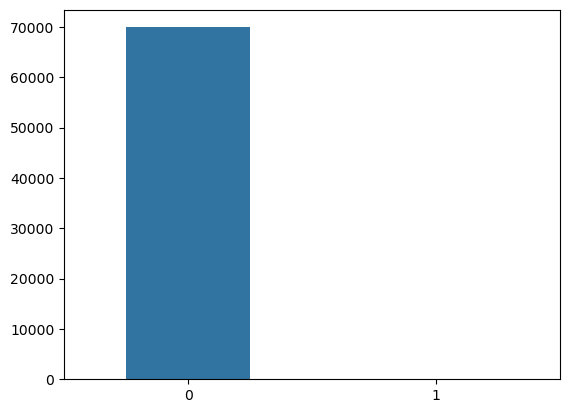

In [ ]:
sns.barplot(x=counts[0], y=counts[1], width=0.5)
plt.show()


### 建構模型

In [ ]:
# 將kernel SVM 擬合到訓練集
from sklearn.svm import LinearSVC
from imblearn.under_sampling import NearMiss
from imblearn import over_sampling as os
from imblearn.pipeline import make_pipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import RandomOverSampler

In [ ]:


# 單純用SVM

pipeline4 = LinearSVC(random_state=1)
pipeline4.fit(X_train, y_train)
counts

(array([0, 1], dtype=int64), array([69904, 69888], dtype=int64))

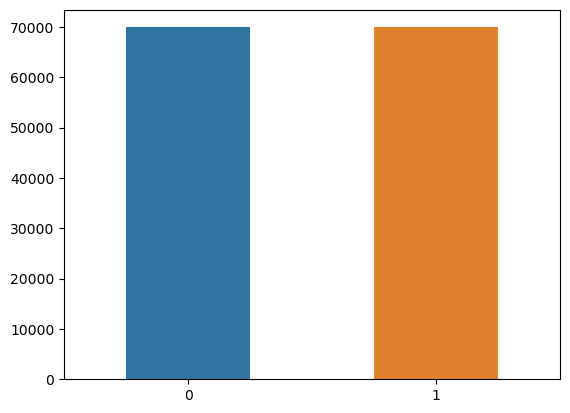

In [ ]:
sns.barplot(x=counts[0],y=counts[1],width=0.5)
plt.show()

### 結果

In [ ]:
# 分類並報告結果
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, pipeline4.predict(X_test)))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.00      1.00      0.00      0.00     14980
          1       0.00      0.00      1.00      0.00      0.00      0.00        20

avg / total       1.00      1.00      0.00      1.00      0.00      0.00     15000



c:\Users\user\anaconda3\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# 製作混淆矩陣
from sklearn.metrics import confusion_matrix, precision_score,auc,roc_auc_score,roc_curve,recall_score
cm = confusion_matrix(y_val, pipeline4.predict(X_val))
roc = roc_auc_score(y_val, pipeline4.predict(X_val))
fpr, tpr, thresholds = roc_curve(y_val, pipeline4.predict(X_val))
roc_auc = auc(fpr,tpr)

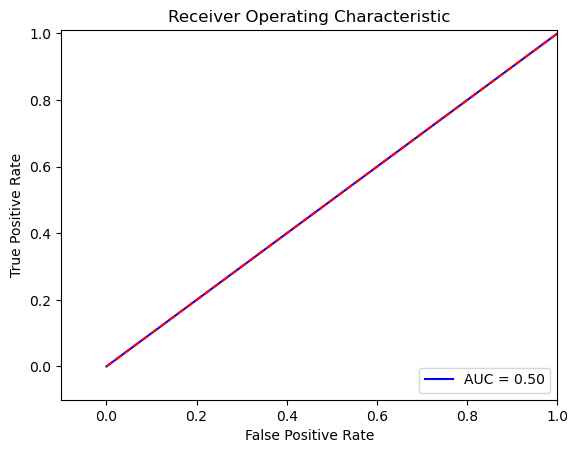

In [ ]:
# 绘制 ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
